In [115]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

# Fit a mesh via rendering

This tutorial shows how to:
- Load a mesh and textures from an `.obj` file. 
- Create a synthetic dataset by rendering a textured mesh from multiple viewpoints
- Fit a mesh to the observed synthetic images using differential silhouette rendering
- Fit a mesh and its textures using differential textured rendering

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [116]:
# import os
# import sys
# import torch
# need_pytorch3d=False
# try:
#     import pytorch3d
# except ModuleNotFoundError:
#     need_pytorch3d=True
# if need_pytorch3d:
#     if torch.__version__.startswith("1.9") and sys.platform.startswith("linux"):
#         # We try to install PyTorch3D via a released wheel.
#         version_str="".join([
#             f"py3{sys.version_info.minor}_cu",
#             torch.version.cuda.replace(".",""),
#             f"_pyt{torch.__version__[0:5:2]}"
#         ])
#         !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
#     else:
#         # We try to install PyTorch3D from source.
#         !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
#         !tar xzf 1.10.0.tar.gz
#         os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
#         !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [117]:
import os
import torch
import matplotlib.pyplot as plt

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
    TexturesUV,
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

In [118]:
# Soft phong shader code
from typing import Tuple
from torch import nn
import torch.nn.functional as F
from pytorch3d.renderer.utils import TensorProperties, convert_to_tensors_and_broadcast
from pytorch3d.ops import interpolate_face_attributes

from typing import Optional
from pytorch3d.common.types import Device
from pytorch3d.structures.meshes import Meshes
from pytorch3d.renderer.blending import (
    BlendParams,
    hard_rgb_blend,
    sigmoid_alpha_blend,
    softmax_rgb_blend,
)
from pytorch3d.renderer.lighting import PointLights
from pytorch3d.renderer.materials import Materials
from pytorch3d.renderer.utils import TensorProperties
from pytorch3d.renderer.mesh.rasterizer import Fragments
from pytorch3d.renderer.mesh.shading import flat_shading, gouraud_shading, phong_shading
from typing import Tuple
from torch import nn
import torch.nn.functional as F
from pytorch3d.renderer.utils import TensorProperties, convert_to_tensors_and_broadcast
from pytorch3d.ops import interpolate_face_attributes

from typing import Optional
from pytorch3d.common.types import Device
from pytorch3d.structures.meshes import Meshes
from pytorch3d.renderer.blending import (
    BlendParams,
    hard_rgb_blend,
    sigmoid_alpha_blend,
    softmax_rgb_blend,
)
from pytorch3d.renderer.lighting import PointLights
from pytorch3d.renderer.materials import Materials
from pytorch3d.renderer.utils import TensorProperties
from pytorch3d.renderer.mesh.rasterizer import Fragments
from pytorch3d.renderer.mesh.shading import flat_shading, gouraud_shading, phong_shading

class NewSoftPhongShader(nn.Module):
    """
    Per pixel lighting - the lighting model is applied using the interpolated
    coordinates and normals for each pixel. The blending function returns the
    soft aggregated color using all the faces per pixel.

    To use the default values, simply initialize the shader with the desired
    device e.g.

    .. code-block::

        shader = SoftPhongShader(device=torch.device("cuda:0"))
    """

    def __init__(
        self,
        device: Device = "cpu",
        cameras: Optional[TensorProperties] = None,
        lights: Optional[TensorProperties] = None,
        materials: Optional[Materials] = None,
        blend_params: Optional[BlendParams] = None,
    ) -> None:
        super().__init__()
        self.lights = lights if lights is not None else PointLights(device=device)
        self.materials = (
            materials if materials is not None else Materials(device=device)
        )
        self.cameras = cameras
        self.blend_params = blend_params if blend_params is not None else BlendParams()

    def to(self, device: Device):
        # Manually move to device modules which are not subclasses of nn.Module
        cameras = self.cameras
        if cameras is not None:
            self.cameras = cameras.to(device)
        self.materials = self.materials.to(device)
        self.lights = self.lights.to(device)
        return self

    def forward(self, fragments: Fragments, meshes: Meshes, **kwargs) -> torch.Tensor:
        cameras = kwargs.get("cameras", self.cameras)
        if cameras is None:
            msg = "Cameras must be specified either at initialization \
                or in the forward pass of SoftPhongShader"
            raise ValueError(msg)

        texels = meshes.sample_textures(fragments)
        mapped_normals = meshes.sample_normalmaps(fragments)
        lights = kwargs.get("lights", self.lights)
        materials = kwargs.get("materials", self.materials)
        blend_params = kwargs.get("blend_params", self.blend_params)
        colors = new_phong_shading(
            meshes=meshes,
            fragments=fragments,
            texels=texels,
            lights=lights,
            cameras=cameras,
            materials=materials,
            mapped_normals=mapped_normals,
        )
        znear = kwargs.get("znear", getattr(cameras, "znear", 1.0))
        zfar = kwargs.get("zfar", getattr(cameras, "zfar", 100.0))
        images = softmax_rgb_blend(
            colors, fragments, blend_params, znear=znear, zfar=zfar
        )
        return images


def new_phong_shading(
    meshes, fragments, lights, cameras, materials, texels, mapped_normals=None
) -> torch.Tensor:
    """
    Apply per pixel shading. First interpolate the vertex normals and
    vertex coordinates using the barycentric coordinates to get the position
    and normal at each pixel. Then compute the illumination for each pixel.
    The pixel color is obtained by multiplying the pixel textures by the ambient
    and diffuse illumination and adding the specular component.

    Args:
        meshes: Batch of meshes
        fragments: Fragments named tuple with the outputs of rasterization
        lights: Lights class containing a batch of lights
        cameras: Cameras class containing a batch of cameras
        materials: Materials class containing a batch of material properties
        texels: texture per pixel of shape (N, H, W, K, 3)

    Returns:
        colors: (N, H, W, K, 3)
    """
    verts = meshes.verts_packed()  # (V, 3)
    faces = meshes.faces_packed()  # (F, 3)
    vertex_normals = meshes.verts_normals_packed()  # (V, 3)
    faces_verts = verts[faces]
    faces_normals = vertex_normals[faces]
    pixel_coords = interpolate_face_attributes(
        fragments.pix_to_face, fragments.bary_coords, faces_verts
    )
    pixel_normals = interpolate_face_attributes(
        fragments.pix_to_face, fragments.bary_coords, faces_normals
    )
    
    # Assume point light source for now
    light_direction = lights.location - pixel_coords
    distance_squared = (light_direction.norm(p=2, dim=-1) ** 1.0).clamp_min(1e-6)
    light_direction = F.normalize(light_direction, p=2, dim=-1, eps=1e-6)
    
    # Tensor conversion
    matched_tensors = convert_to_tensors_and_broadcast(
        pixel_normals, 
        lights.diffuse_color,
        lights.specular_color,
        light_direction,
        cameras.get_camera_center(),
        materials.shininess,
        device=pixel_normals.device)
    
    # Reshape tensors
    points_dims = pixel_normals.shape[1:-1]
    expand_dims = (-1,) + (1,) * len(points_dims)
    for i, tensor in enumerate(matched_tensors): 
        if tensor.shape != pixel_normals.shape:
            matched_tensors[i] = tensor.view(
                expand_dims if i==len(matched_tensors)-1 else expand_dims + (3,)
            )   # Careful reshaping shininess
    
    normals, light_diffuse_color, light_specular_color, \
        light_direction, camera_position, shininess = matched_tensors
    
    #   Apply lighting
    view_direction = camera_position - pixel_coords
    view_direction = F.normalize(view_direction, p=2, dim=-1, eps=1e-6)
    # normals = F.normalize()
    # print(normals.shape, texels.shape, mapped_normals.shape)
    # normals = F.normalize(normals, p=2, dim=-1, eps=1e-6)
    # print(normals.shape)

    diffuse_intensity = \
        F.relu(torch.sum(mapped_normals * light_direction, dim=-1)) / distance_squared
    light_diffuse = light_diffuse_color * diffuse_intensity[..., None]
    
    halfway_vector = light_direction + view_direction
    halfway_vector = F.normalize(halfway_vector, p=2, dim=-1, eps=1e-6)
    specular_intensity = (F.relu(
        torch.sum(mapped_normals * halfway_vector, dim=-1)
    ) ** shininess) / distance_squared
    light_specular = light_specular_color * specular_intensity[..., None]


    
    ambient_color = materials.ambient_color * lights.ambient_color
    diffuse_color = materials.diffuse_color * light_diffuse
    specular_color = materials.specular_color * light_specular

    if pixel_normals.dim() == 2 and pixel_coords.dim() == 2:
        # If given packed inputs remove batch dim in output.
        return (
            ambient_color.squeeze(),
            diffuse_color.squeeze(),
            specular_color.squeeze(),
        )

    if ambient_color.ndim != diffuse_color.ndim:
        # Reshape from (N, 3) to have dimensions compatible with
        # diffuse_color which is of shape (N, H, W, K, 3)
        ambient_color = ambient_color[:, None, None, None, :]

    colors = (ambient_color + diffuse_color) * texels + specular_color
    return colors

If using **Google Colab**, fetch the utils file for plotting image grids:

In [119]:
# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
# from plot_image_grid import image_grid

OR if running **locally** uncomment and run the following cell:

In [120]:
 from utils.plot_image_grid import image_grid

### 1. Load a mesh and texture file

Load an `.obj` file and its associated `.mtl` file and create a **Textures** and **Meshes** object. 

**Meshes** is a unique datastructure provided in PyTorch3D for working with batches of meshes of different sizes. 

**TexturesVertex** is an auxiliary datastructure for storing vertex rgb texture information about meshes. 

**Meshes** has several class methods which are used throughout the rendering pipeline.

If running this notebook using **Google Colab**, run the following cell to fetch the mesh obj and texture files and save it at the path `data/cow_mesh`:
If running locally, the data is already available at the correct path. 

In [121]:
# !mkdir -p data/cow_mesh
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

In [122]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));

torch.Size([1, 1024, 1024, 3])


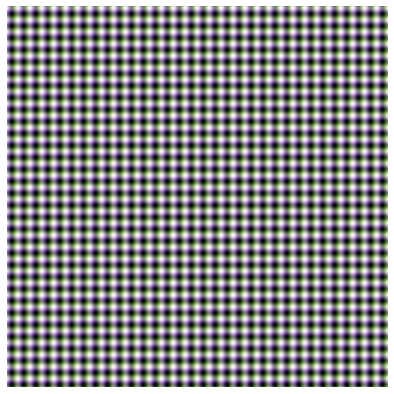

In [123]:
plt.figure(figsize=(7,7))
texture_image=mesh.normalmaps.maps_padded()
print(texture_image.shape)
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.axis("off");

## 2. Dataset Creation

We sample different camera positions that encode multiple viewpoints of the cow.  We create a renderer with a shader that performs texture map interpolation.  We render a synthetic dataset of images of the textured cow mesh from multiple viewpoints.


In [159]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 20
imsize = 128
# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -1.0]])

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
# Changed to novel view
rand_elev = torch.rand((1,))*360
rand_azim = torch.rand((1,))*360 - 180
R_novel, T_novel = look_at_view_transform(dist=2.7, elev=rand_elev, azim=rand_azim)

camera = OpenGLPerspectiveCameras(device=device, R=R_novel, 
                                  T=T_novel) 


# camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
#                                   T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using heuristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=imsize, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    perspective_correct=False,
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights
    )
)

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(num_views)

# Render the cow mesh from each viewing angle
target_images = renderer(meshes, cameras=cameras, lights=lights)

# Our multi-view cow dataset will be represented by these 2 lists of tensors,
# each of length num_views.
target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
target_cameras = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(num_views)]

random_target = renderer(mesh, cameras=camera, lights=lights)[...,:3]
print(random_target.shape)

torch.Size([1, 128, 128, 3])


/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


Visualize the dataset:

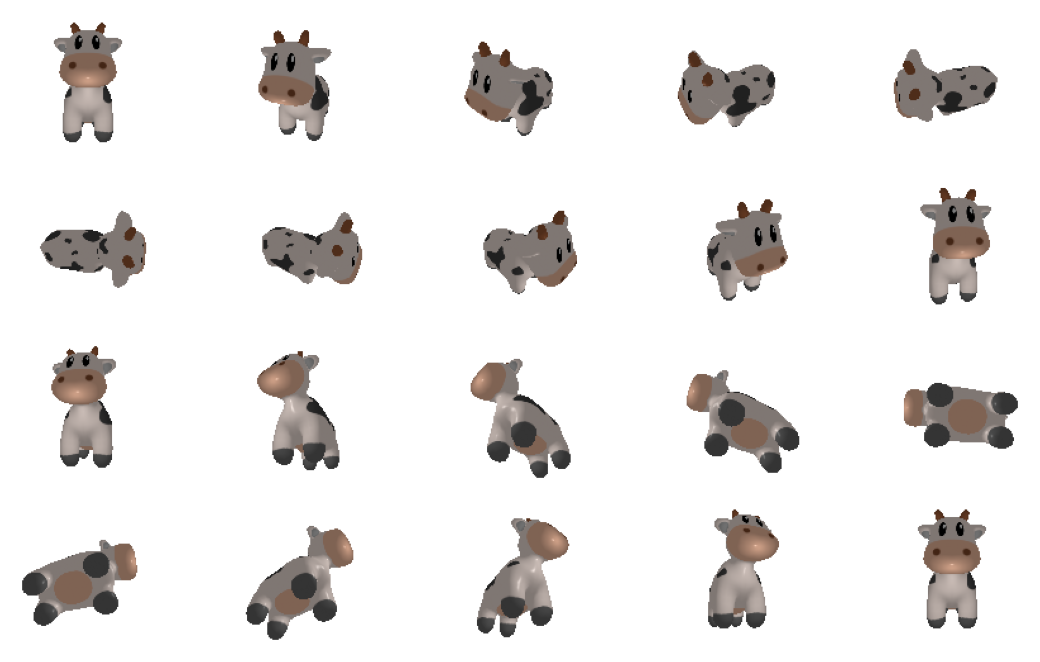

In [160]:
# RGB images
image_grid(target_images.cpu().numpy(), rows=4, cols=5, rgb=True)
plt.show()

Later in this tutorial, we will fit a mesh to the rendered RGB images, as well as to just images of just the cow silhouette.  For the latter case, we will render a dataset of silhouette images.  Most shaders in PyTorch3D will output an alpha channel along with the RGB image as a 4th channel in an RGBA image.  The alpha channel encodes the probability that each pixel belongs to the foreground of the object.  We construct a soft silhouette shader to render this alpha channel.

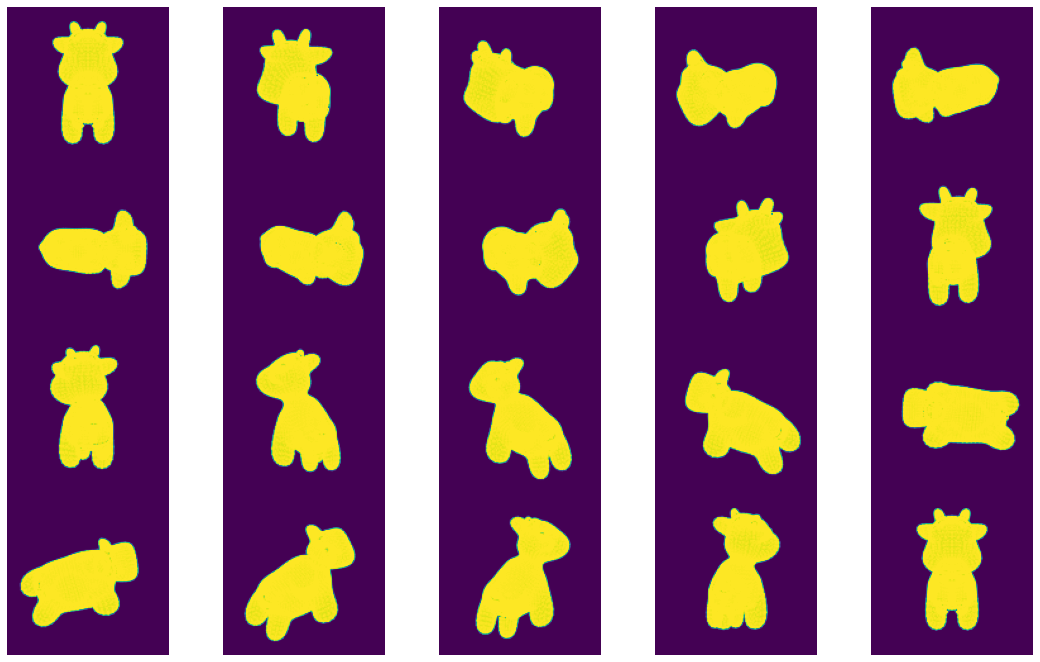

In [161]:
# Rasterization settings for silhouette rendering  
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=imsize, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False,
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Render silhouette images.  The 3rd channel of the rendering output is 
# the alpha/silhouette channel
silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# Visualize silhouette images
image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
plt.show()

## 3. Mesh prediction via silhouette rendering
In the previous section, we created a dataset of images of multiple viewpoints of a cow.  In this section, we predict a mesh by observing those target images without any knowledge of the ground truth cow mesh.  We assume we know the position of the cameras and lighting.

We first define some helper functions to visualize the results of our mesh prediction:

In [173]:
# Show a visualization comparing the rendered predicted mesh to the ground truth 
# mesh
def visualize_prediction(predicted_mesh, renderer=renderer_silhouette, 
                         target_image=random_target[0], title='', 
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

Starting from a sphere mesh, we will learn offsets of each vertex such that the predicted mesh silhouette is more similar to the target silhouette image at each optimization step.  We begin by loading our initial sphere mesh:

In [174]:
# We initialize the source shape to be a sphere of radius 1.  
src_mesh = ico_sphere(4, device)
# src_mesh = mesh.clone()

We create a new differentiable renderer for rendering the silhouette of our predicted mesh:

In [175]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=imsize, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False,
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)

We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target silhouettes:

In [176]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 2
# Number of optimization steps
Niter = 10
# Plot period for the losses
plot_period = 250

%matplotlib inline

# Optimize using rendered silhouette image loss, mesh edge loss, mesh normal 
# consistency, and mesh laplacian smoothing
losses = {"silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)
    
    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)
    
    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

We write an optimization loop to iteratively refine our predicted mesh from the sphere mesh into a mesh that matches the silhouettes of the target images:

  0%|          | 0/10 [00:00<?, ?it/s]

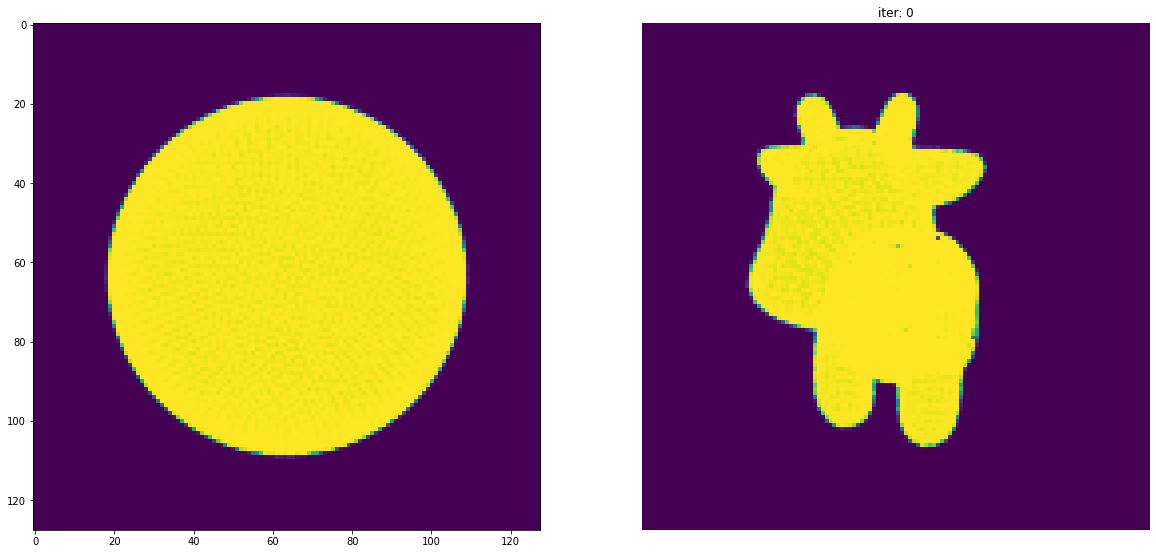

In [177]:
loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)
    
    # Compute the average silhouette loss over two random views, as the average 
    # squared L2 distance between the predicted silhouette and the target 
    # silhouette from our dataset
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration
    
    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))

    
    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)
    
    # Plot mesh
    if i % plot_period == 0:
        visualize_prediction(new_src_mesh, title="iter: %d" % i, silhouette=True,
                             target_image=target_silhouette[1])
        
    # Optimization step
    sum_loss.backward()
    optimizer.step()

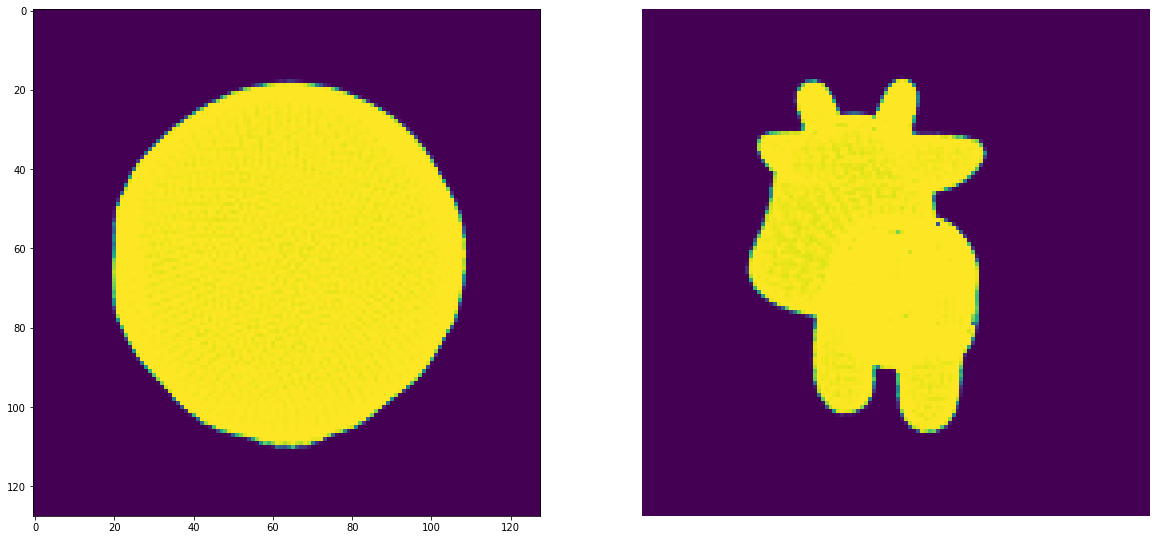

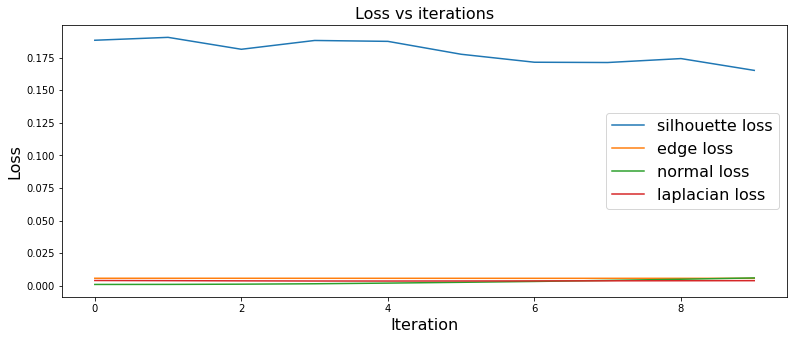

In [178]:
visualize_prediction(new_src_mesh, silhouette=True, 
                     target_image=target_silhouette[1])
plot_losses(losses)

## 3. Mesh and texture prediction via textured rendering
We can predict both the mesh and its texture if we add an additional loss based on the comparing a predicted rendered RGB image to the target image. As before, we start with a sphere mesh.  We learn both translational offsets and RGB texture colors for each vertex in the sphere mesh.  Since our loss is based on rendered RGB pixel values instead of just the silhouette, we use a **SoftPhongShader** instead of a **SoftSilhouetteShader**.

In [210]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=imsize, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False,
)

# Differentiable soft renderer using per vertex RGB colors for texture
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftPhongShader(device=device, 
        cameras=camera,
        lights=lights)
)


We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target RGB images:

In [211]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 5
# Number of optimization steps
Niter = 10000
# Plot period for the losses
plot_period = Niter // 5

%matplotlib inline

# Optimize using rendered RGB image loss, rendered silhouette image loss, mesh 
# edge loss, mesh normal consistency, and mesh laplacian smoothing
losses = {
          "rgb": {"weight": 1.0, "values": []},
        #   "silhouette": {"weight": 1.0, "values": []},
        #   "edge": {"weight": 1.0, "values": []},
        #   "normal": {"weight": 0.01, "values": []},
        #   "laplacian": {"weight": 1.0, "values": []},
          # "style": {"weight": 1.0, "values": []},
          "adversarial": {"weight": 0.000, "values": []},
          "smoothness":{"weight":0.00, "values": []}
         }
losses_gan = {
          "generator": {"weight": 1.0, "values": []},
          "discriminator":{"weight":1.0, "values": []}

}
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in 
# src_mesh
src_mesh = mesh.clone()
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

verts = src_mesh.verts_packed().to(device)
faces = src_mesh.faces_packed().unsqueeze(dim=0).to(device)
# u = 0.5 + (torch.atan2(verts[:,0], verts[:,1])/(np.pi*2))
# v = 0.5 - (torch.arcsin(verts[:,2])/np.pi)
# uv_map = torch.stack([u,v], dim=1).unsqueeze(dim=0).to(device)
uv_map = src_mesh.textures.verts_uvs_padded().to(device)
# uv_map.requires_grad = True

# We will also learn per vertex colors for our sphere mesh that define texture 
# of the mesh
# sphere_verts_rgb = torch.full(mesh.textures.maps_padded().shape, 0.1, device=device, requires_grad=True)
# sphere_verts_rgb = torch.normal(mean=torch.full(mesh.textures.maps_padded().shape, 0.5),std=0.05).to(device)
# sphere_verts_rgb.requires_grad = True
# print(sphere_verts_rgb)

# Need to create UV map for the sphere and optimize that together with the texture

# The optimizer
# optimizer = torch.optim.Adam([sphere_verts_rgb], lr=0.001)
# new_src_mesh = src_mesh.clone()
# new_src_mesh.textures = TexturesUV(sphere_verts_rgb, faces_uvs=faces, verts_uvs=uv_map)



We write an optimization loop to iteratively refine our predicted mesh and its vertex colors from the sphere mesh into a mesh that matches the target images:

In [212]:
# Style loss code
from torchvision.transforms import RandomAffine, Resize
import torchvision.models as models

# cnn = models.vgg19(pretrained=True).features.to(device).eval()


def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

# desired depth layers to compute style/content losses :
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses

In [213]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, true_img, fake_img, transform=None, target_transform=None):
        self.img_labels = np.concatenate((np.full(len(true_img), real_label), np.full(len(fake_img), fake_label)))
        self.transform = transform
        self.target_transform = target_transform
        self.true_img = true_img
        self.fake_img = fake_img

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        if idx < len(self.true_img):
            image = self.true_img[idx]
        else:
            image = self.fake_img[idx - len(self.true_img)]

        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

  0%|          | 0/10000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 100, 1, 1])
torch.Size([1, 1024, 1024, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


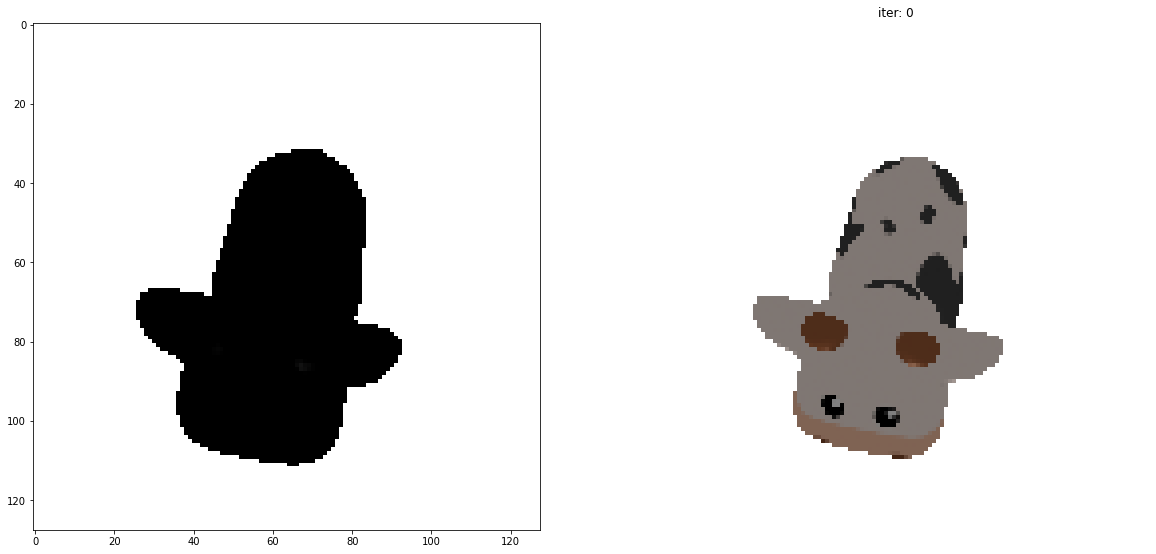

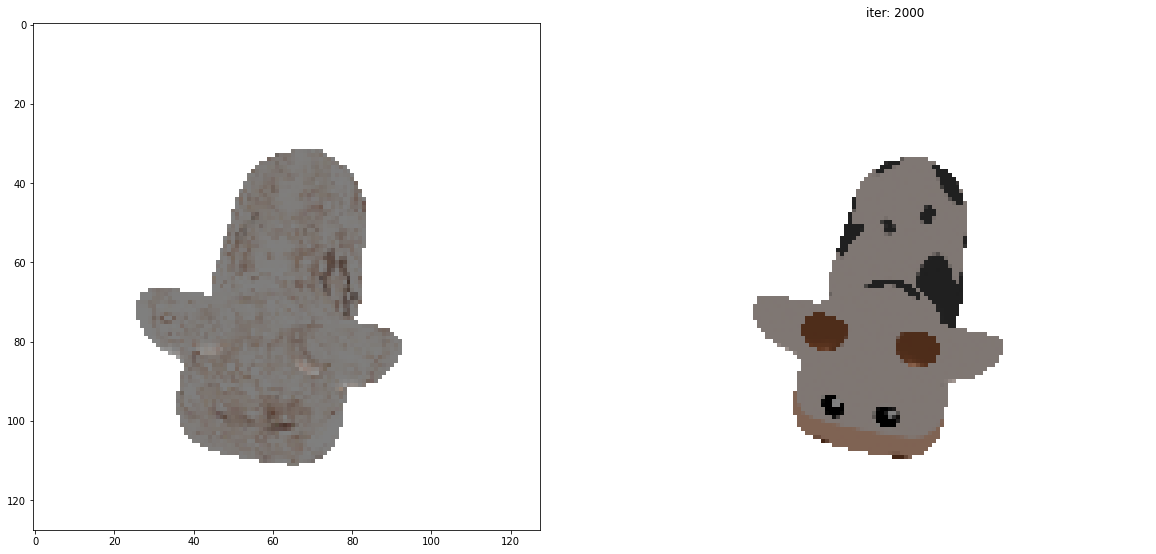

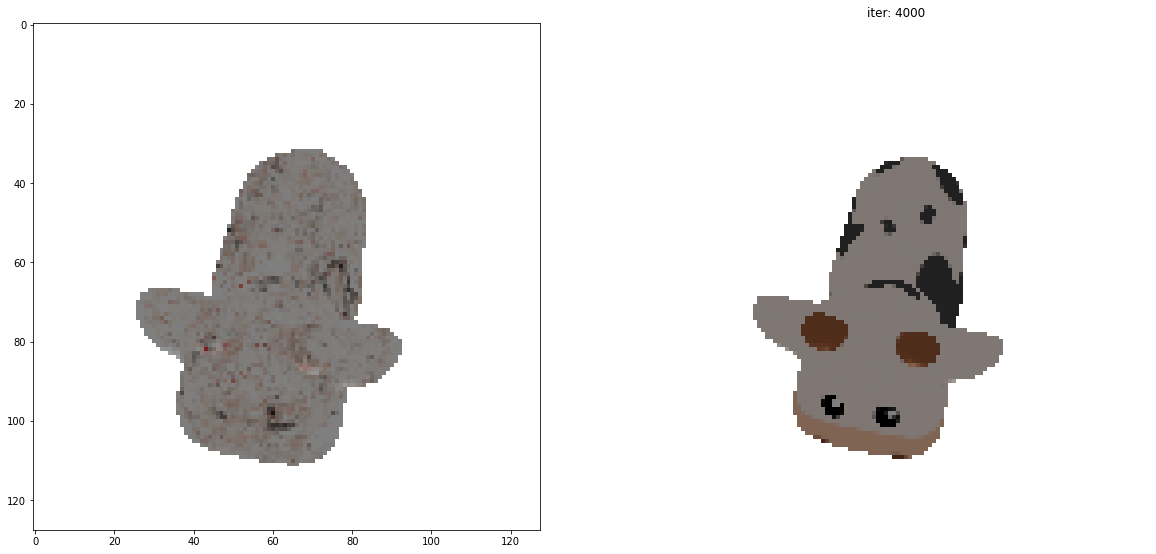

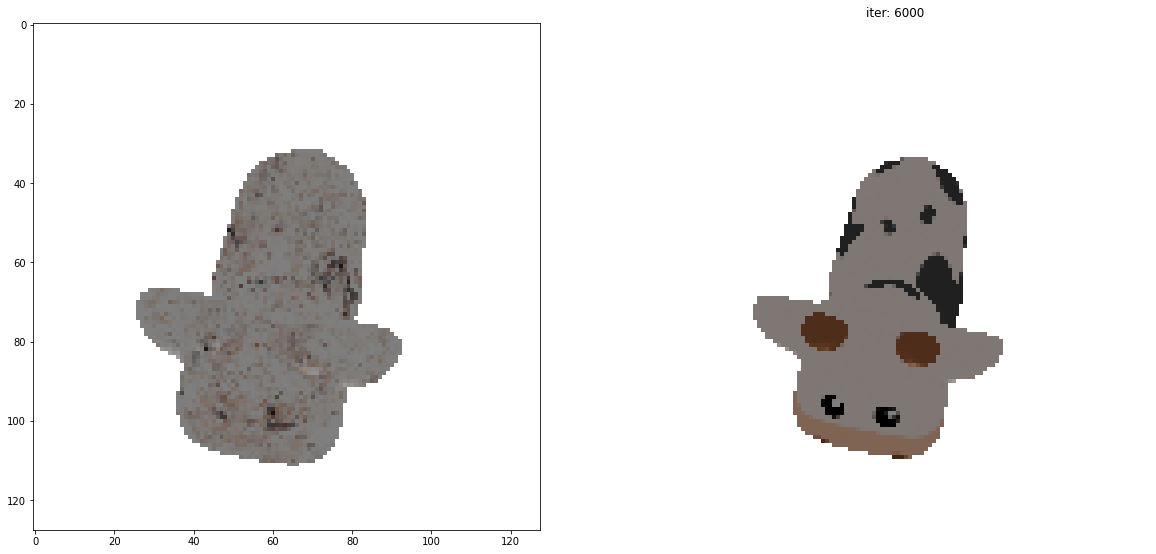

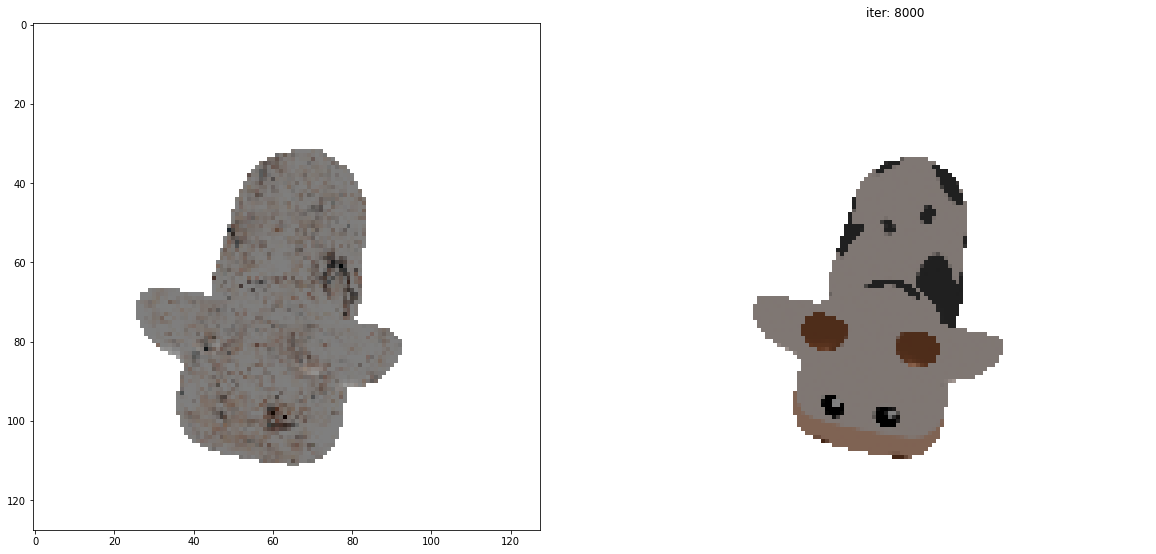

In [221]:
import torch.utils.data
loop = tqdm(range(Niter))
# maps = [sphere_verts_rgb.detach().cpu()]


# Adversarial loss from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
nc = 3
ndf = 32
ngf = 16
nz = 100
class ResConvTranspose(nn.Module):
    layer = 0
    def __init__(self, deconv, upsampler):
        super().__init__()
        self.module = deconv
        self.upsampler = upsampler

    def forward(self, inputs):
        return self.module(inputs) + self.upsampler(inputs)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            # state size. (ndf*8) x 8 x 8
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Texture generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            # nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            # ResConvTranspose(nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
            # nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            # ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
            # nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            # ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
            # nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf) x 32 x 32
            # nn.ConvTranspose2d( ngf, ngf//2, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf//2),
            # nn.ReLU(True),
            # nn.Dropout2d(),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 4, 0, bias=False),
            nn.Tanh(),
            # nn.Upsample(scale_factor=4, mode='bilinear')
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# Create discriminator for adversarial loss
ngpu = 1
workers = 2
lr = 0.001
beta1 = 0.5
bce_loss = nn.BCELoss()
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
real_label = 1.
fake_label = 0.
optimizerD = torch.optim.SGD(netD.parameters(), lr=lr*0.001)


# Create the generator
netG = Generator(ngpu).to(device)
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Need to create UV map for the sphere and optimize that together with the texture
# The optimizer
# optimizer = torch.optim.Adam([sphere_verts_rgb], lr=0.001)
# new_src_mesh = src_mesh.clone()
# new_src_mesh.textures = TexturesUV(sphere_verts_rgb, faces_uvs=faces, verts_uvs=uv_map)

# Need to create UV map for the sphere and optimize that together with the texture

# The optimizer
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
random_vector = torch.randn(1, nz, 1, 1, device=device) * 0.5
print(random_vector.shape)
sphere_verts_rgb = netG(random_vector).permute(0,2,3,1)
new_src_mesh = src_mesh.clone()
new_src_mesh.textures = TexturesUV(sphere_verts_rgb, faces_uvs=faces, verts_uvs=uv_map)
print(new_src_mesh.normalmaps.maps_padded().shape)



for i in loop:
    transform_range_horizontal = 1/sphere_verts_rgb.shape[1]
    transform_range_vertical = 1/sphere_verts_rgb.shape[2]
    transform = RandomAffine(0, translate=(transform_range_horizontal,transform_range_vertical))
    # Initialize optimizer
    optimizerG.zero_grad()
    
    # Deform the mesh
    # new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # Add per vertex colors to texture the mesh
    # TODO create UV map for faces and vertices for the default sphere
    sphere_verts_rgb = netG(random_vector).permute(0,2,3,1)
    new_src_mesh.textures = TexturesUV(sphere_verts_rgb, faces_uvs=faces, verts_uvs=uv_map)
    
    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    # update_mesh_shape_prior_losses(new_src_mesh, loss)
    loss_gan = {k: torch.tensor(0.0, device=device) for k in losses_gan}

    # Randomly select two views to optimize over in this iteration.  Compared
    # to using just one view, this helps resolve ambiguities between updating
    # mesh shape vs. updating mesh texture
    rendered_rgb = []

    # Getting examples from renderer as the Generator
    random_views = np.random.permutation(num_views).tolist()[:num_views_per_iteration]
    for j in random_views:
        images_predicted = renderer_textured(new_src_mesh, cameras=target_cameras[j], lights=lights)

        # Squared L2 distance between the predicted silhouette and the target 
        # # silhouette from our dataset
        # predicted_silhouette = images_predicted[..., 3]
        # loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        # loss["silhouette"] += loss_silhouette / num_views_per_iteration
        
        # Squared L2 distance between the predicted RGB image and the target 
        predicted_rgb = images_predicted[..., :3]
        rendered_rgb.append(predicted_rgb.squeeze())
        loss_rgb = ((predicted_rgb - target_rgb[j]) ** 2).mean()

        # Style loss WIP
        # target_rgb[j].clone().detach().permute(2,0,1).unsqueeze(0)
        # model, style_losses = get_style_model_and_losses(cnn, cnn_normalization_mean, cnn_normalization_std, target_rgb[j].clone().detach().permute(2,0,1).unsqueeze(0))
        # model_input = sphere_verts_rgb.clone().detach().to(device).permute(0,3,1,2)
        # model(model_input)
        # style_score = 0
        # for sl in style_losses:
        #     style_score += sl.loss

        # Shifted image to get the image to be smoother/gradient between pixels to be smoother
        # smoothness = ((sphere_verts_rgb - transform(sphere_verts_rgb.permute(0,3,1,2)).permute(0,2,3,1))**2).mean()

        loss["rgb"] += loss_rgb / num_views_per_iteration
        # loss["smoothness"] += smoothness / num_views_per_iteration
        # loss["style"] += style_score / num_views_per_iteration

    # ############################
    # # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    # ###########################
    # ## Train with all-real batch
    # netD.zero_grad()
    # # Format batch
    # real_cpu = torch.stack([target_rgb[i] for i in random_views], dim=0).permute(0,3,1,2)
    # real_cpu = real_cpu + torch.randn(real_cpu.size(), device=device)*0.1
    # b_size = num_views_per_iteration
    # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    # # Forward pass real batch through D
    # output = netD(real_cpu).view(-1)
    # # Calculate loss on all-real batch
    # errD_real = bce_loss(output, label)
    # # Calculate gradients for D in backward pass
    # errD_real.backward()
    # D_x = output.mean().item()

    # ## Train with all-fake batch
    # # Generate batch of latent vectors
    # # Generate fake image batch with G
    # fake = torch.stack(rendered_rgb, dim=0).permute(0,3,1,2) + torch.randn(real_cpu.size(), device=device)*0.1
    # label.fill_(fake_label)
    # # Classify all fake batch with D
    # output = netD(fake).view(-1)
    # # Calculate D's loss on the all-fake batch
    # errD_fake = bce_loss(output, label)
    # # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    # errD_fake.backward(retain_graph=True)
    # D_G_z1 = output.mean().item()
    # # Compute error of D as sum over the fake and the real batches
    # errD = errD_real + errD_fake
    # # Update D
    # optimizerD.step()

    # ############################
    # # (2) Update G network: maximize log(D(G(z)))
    # ###########################
    # label.fill_(real_label)  # fake labels are real for generator cost
    # # Since we just updated D, perform another forward pass of all-fake batch through D
    # output = netD(fake).view(-1)
    # # Calculate G's loss based on this output
    # errG = bce_loss(output, label)
    # # Calculate gradients for G
    # # D_G_z2 = output.mean().item()
    # # Update G

    # loss["adversarial"] = errG / num_views_per_iteration
    # loss_gan["generator"] = errG / num_views_per_iteration
    # loss_gan["discriminator"] = errD / num_views_per_iteration / 2

    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))
    

    for k, l in loss_gan.items():
        losses_gan[k]["values"].append(float(l.detach().cpu()))
    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)
    
    # Plot mesh
    if i % plot_period == 0:
        visualize_prediction(new_src_mesh, renderer=renderer_textured, title="iter: %d" % i, silhouette=False)
        # maps.append(sphere_verts_rgb.detach().cpu())
        
    # Optimization step
    sum_loss.backward()
    optimizerG.step()

    # Train Discriminator
    # I want to make a generator that will create patches from the texture and warp them somehow to simulate them being on a surface. I'm thinking of some gradient mask too so that we don't learn from empty space. 
    # The true examples would be patches from the real image (probably also good to make it so that the object makes up at least some proportion of the patch for it to be accepted)

    # Train Texture/Generator
    # Here I want to use the discriminator to learn the texture better to try and fool it with the renderer serving as generator and the texture being the parameters we are tweaking/learning. 
    


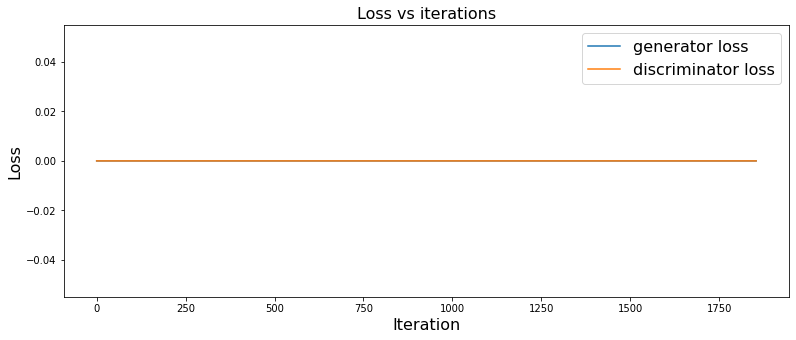

In [218]:
plot_losses(losses_gan)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


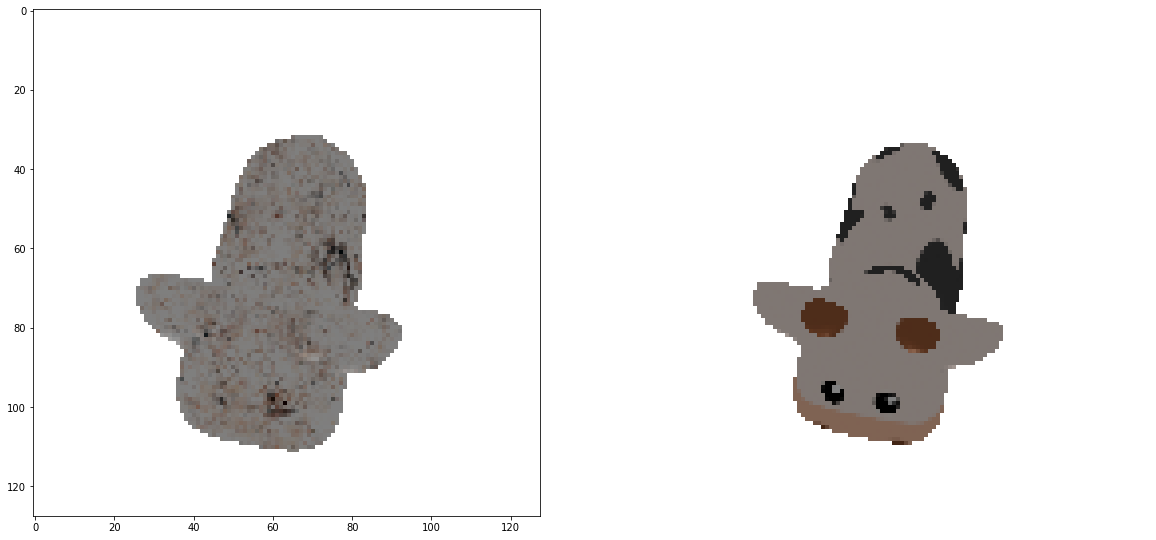

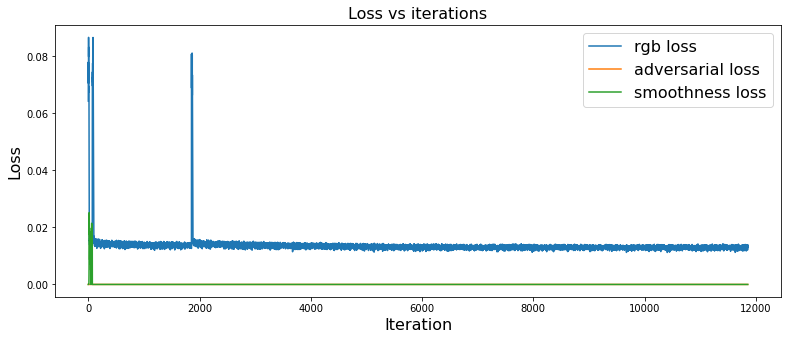

In [222]:
visualize_prediction(new_src_mesh, renderer=renderer_textured, silhouette=False)
plot_losses(losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


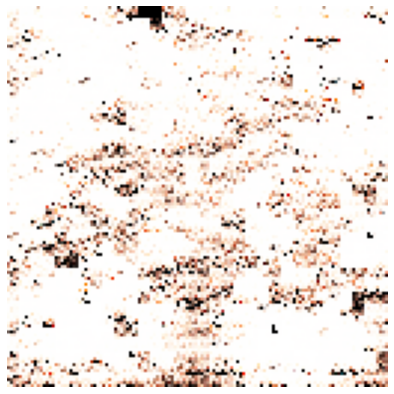

In [223]:
plt.figure(figsize=(7,7))
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

texture_image=new_src_mesh.textures.maps_padded()
# texturesuv_image_matplotlib(new_src_mesh.textures, subsample=None)

# print(texture_image.shape)
plt.imshow(texture_image.squeeze().cpu().detach())
plt.axis("off");

Save the final predicted mesh:

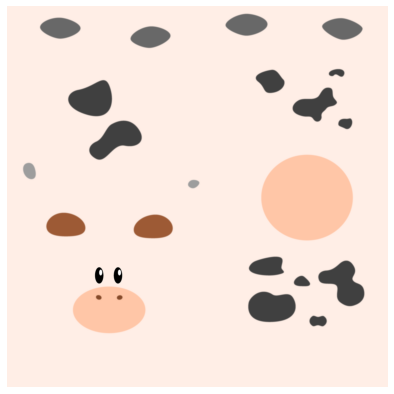

In [29]:
plt.figure(figsize=(7,7))
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

texture_image=src_mesh.textures.maps_padded()
# texturesuv_image_matplotlib(mesh.textures, subsample=None)
# print(src_mesh.textures.maps_padded().shape, new_src_mesh.textures.maps_padded().shape)
# print(texture_image.shape)
plt.imshow(texture_image.squeeze().cpu().detach())
plt.axis("off");

## 4. Save the final predicted mesh

In [ ]:
# # Fetch the verts and faces of the final predicted mesh
# final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# # Scale normalize back to the original target size
# final_verts = final_verts * scale + center

# # Store the predicted mesh using save_obj
# final_obj = os.path.join('./', 'final_model.obj')
# save_obj(final_obj, final_verts, final_faces)

## 5. Conclusion
In this tutorial, we learned how to load a textured mesh from an obj file, create a synthetic dataset by rendering the mesh from multiple viewpoints.  We showed how to set up an optimization loop to fit a mesh to the observed dataset images based on a rendered silhouette loss.  We then augmented this optimization loop with an additional loss based on rendered RGB images, which allowed us to predict both a mesh and its texture.